## Import Libraries and Load Data

In [1]:
# Importing the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score

# Load the datasets
customers_df = pd.read_csv('Customers.csv')
transactions_df = pd.read_csv('Transactions.csv')

# Preview the datasets
customers_df.head(), transactions_df.head()


(  CustomerID        CustomerName         Region  SignupDate
 0      C0001    Lawrence Carroll  South America  2022-07-10
 1      C0002      Elizabeth Lutz           Asia  2022-02-13
 2      C0003      Michael Rivera  South America  2024-03-07
 3      C0004  Kathleen Rodriguez  South America  2022-10-09
 4      C0005         Laura Weber           Asia  2022-08-15,
   TransactionID CustomerID ProductID      TransactionDate  Quantity  \
 0        T00001      C0199      P067  2024-08-25 12:38:23         1   
 1        T00112      C0146      P067  2024-05-27 22:23:54         1   
 2        T00166      C0127      P067  2024-04-25 07:38:55         1   
 3        T00272      C0087      P067  2024-03-26 22:55:37         2   
 4        T00363      C0070      P067  2024-03-21 15:10:10         3   
 
    TotalValue   Price  
 0      300.68  300.68  
 1      300.68  300.68  
 2      300.68  300.68  
 3      601.36  300.68  
 4      902.04  300.68  )

## Data Preprocessing

Merge the datasets on CustomerID to combine customer profile and transaction data.
Handle missing values by either filling or dropping them.
Feature Engineering: Create new features like TotalSpend (sum of transaction values), TotalQuantity (sum of quantities), and TransactionCount (count of transactions).

In [2]:
# Merge the data on CustomerID
df = pd.merge(transactions_df, customers_df, on='CustomerID', how='inner')

# Handle missing values (e.g., drop rows with missing values)
df.dropna(inplace=True)

# Feature Engineering: Total Spend, Total Quantity, Transaction Count per Customer
customer_summary = df.groupby('CustomerID').agg(
    TotalSpend=('TotalValue', 'sum'),
    TotalQuantity=('Quantity', 'sum'),
    TransactionCount=('TransactionID', 'count')
).reset_index()

# Merge with customer demographic information (Region, SignupDate)
customer_summary = pd.merge(customer_summary, customers_df[['CustomerID', 'Region']], on='CustomerID', how='left')

# Preview the customer summary
customer_summary.head()


,CustomerID,TotalSpend,TotalQuantity,TransactionCount,Region
0,C0001,3354.52,12,5,South America
1,C0002,1862.74,10,4,Asia
2,C0003,2725.38,14,4,South America
3,C0004,5354.88,23,8,South America
4,C0005,2034.24,7,3,Asia


##  Encode Categorical Features

Encode categorical features like Region (e.g., one-hot encoding) to prepare for clustering.

In [3]:
# One-hot encode the 'Region' column
customer_summary = pd.get_dummies(customer_summary, columns=['Region'], drop_first=True)

# Preview the encoded data
customer_summary.head()


,CustomerID,TotalSpend,TotalQuantity,TransactionCount,Region_Europe,Region_North America,Region_South America
0,C0001,3354.52,12,5,False,False,True
1,C0002,1862.74,10,4,False,False,False
2,C0003,2725.38,14,4,False,False,True
3,C0004,5354.88,23,8,False,False,True
4,C0005,2034.24,7,3,False,False,False


## Scaling Features
Since clustering algorithms like K-Means are sensitive to the scale of the data, we’ll standardize the features to have zero mean and unit variance.

In [4]:
# Select features for clustering
features = ['TotalSpend', 'TotalQuantity', 'TransactionCount'] + [col for col in customer_summary.columns if 'Region' in col]

# Standardize the features
scaler = StandardScaler()
customer_summary_scaled = scaler.fit_transform(customer_summary[features])

# Preview the scaled data
customer_summary_scaled[:5]


array([[-0.06170143, -0.12203296, -0.01145819, -0.57928445, -0.54831888,
         1.54041597],
       [-0.87774353, -0.44800021, -0.46749414, -0.57928445, -0.54831888,
        -0.6491753 ],
       [-0.40585722,  0.20393428, -0.46749414, -0.57928445, -0.54831888,
         1.54041597],
       [ 1.03254704,  1.67078689,  1.35664965, -0.57928445, -0.54831888,
         1.54041597],
       [-0.78392861, -0.93695108, -0.92353008, -0.57928445, -0.54831888,
        -0.6491753 ]])

## Apply K-Means Clustering
We will apply K-Means clustering to the scaled data, varying the number of clusters K between 2 and 10. We'll also calculate the Davies-Bouldin Index to evaluate the clustering.

C:\Users\tyagi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\tyagi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\tyagi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\tyagi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are

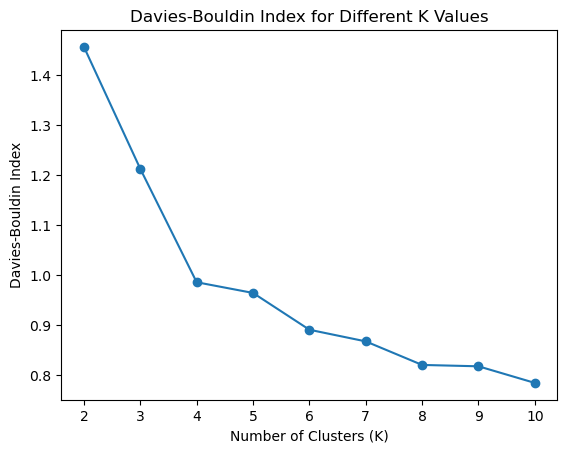

In [5]:
# Choose K values to test (2 to 10 clusters)
k_range = range(2, 11)
db_index = []

# Run K-Means for each K and calculate the Davies-Bouldin Index
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(customer_summary_scaled)
    db_index.append(davies_bouldin_score(customer_summary_scaled, kmeans.labels_))

# Plot the Davies-Bouldin Index for each K value
plt.plot(k_range, db_index, marker='o')
plt.title('Davies-Bouldin Index for Different K Values')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Davies-Bouldin Index')
plt.show()


## Optimal Clusters and Perform Clustering
From the previous plot, select the optimal K based on the lowest Davies-Bouldin Index. For example, let's assume K=4 is the best.

In [6]:
# Apply K-Means with the chosen K (let's assume 4 clusters)
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
customer_summary['Cluster'] = kmeans.fit_predict(customer_summary_scaled)

# Add cluster centers and labels to the dataframe
cluster_centers = pd.DataFrame(kmeans.cluster_centers_, columns=features)
print(cluster_centers)


C:\Users\tyagi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\tyagi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


   TotalSpend  TotalQuantity  TransactionCount  Region_Europe  \
0   -0.334505      -0.272793         -0.171071      -0.579284   
1   -0.597360      -0.648390         -0.631966      -0.579284   
2   -0.245784      -0.320448         -0.308873       1.726268   
3    1.175486       1.253925          1.146172      -0.401934   

   Region_North America  Region_South America  
0              1.823756             -0.649175  
1             -0.548319              0.607148  
2             -0.548319             -0.649175  
3             -0.274618              0.361405  


##  Visualize the Clusters
To visualize the clusters, we will use PCA to reduce the dimensionality of the features to 2D for easy plotting.

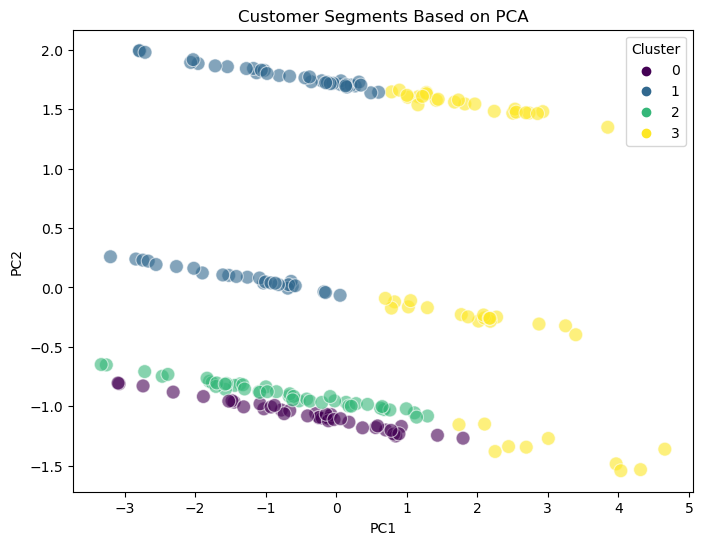

In [7]:
# Perform PCA for dimensionality reduction to 2D
pca = PCA(n_components=2)
principal_components = pca.fit_transform(customer_summary_scaled)

# Create a DataFrame with PCA components and cluster labels
pca_df = pd.DataFrame(principal_components, columns=['PC1', 'PC2'])
pca_df['Cluster'] = customer_summary['Cluster']

# Plot the clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=pca_df, palette='viridis', s=100, alpha=0.6, edgecolor='w')
plt.title('Customer Segments Based on PCA')
plt.show()


## Evaluate and Report Results
Finally, we will evaluate the clustering results, reporting the number of clusters and the Davies-Bouldin Index.

In [8]:
# Output the number of clusters and the Davies-Bouldin Index
print(f'Optimal Number of Clusters: {optimal_k}')
print(f'Davies-Bouldin Index: {min(db_index)}')


Optimal Number of Clusters: 4
Davies-Bouldin Index: 0.7848748526738407


## Save the Results
We can save the clustered data to a CSV file for further analysis or reporting.

In [9]:
# Save the segmented data with clusters to a CSV
customer_summary.to_csv('Customer_Segmentation.csv', index=False)
